This is a pet project to visualise population tracking. Dataset is obtain from open-sourced data officially published by MoH. Done before CovidNOW was created. For better visuals visit: 
https://covidnow.moh.gov.my/


checkin_malaysia.csv [done]
- national average no. of location visited per capita by month
- national no. of people outside of residential area by day
- national average no. of location visited per capita by day
- national average no. of location visited per capita by week day

checkin_malaysia_time.csv
- peak hours 30 mins interval
- peak hours & cold hours by each week day 

checkin_state.csv
- state average no. of location visited per capita by month
- state no. of people outside of residential area by day
- state average no. of location visited per capita by day
- state average no. of location visited per capita by week day

trace_malaysia.csv
- national no. of casual contacts and hotspots detected

In [ ]:
%pip install ipympl
%matplotlib widget
%matplotlib inline

In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

class PopulationTraffic():

    def __init__(self):
        self.MONTHS = 12
        self.WEEKDAYS = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        self.CHECKIN_N = pd.read_csv('https://raw.githubusercontent.com/MoH-Malaysia/covid19-public/main/mysejahtera/checkin_malaysia.csv')
        self.CHECKIN_S       = pd.read_csv('https://raw.githubusercontent.com/MoH-Malaysia/covid19-public/main/mysejahtera/checkin_state.csv')
        self.CHECKIN_TIME_N  = pd.read_csv('https://raw.githubusercontent.com/MoH-Malaysia/covid19-public/main/mysejahtera/checkin_malaysia_time.csv')
        self.TRACE_N         = pd.read_csv('https://raw.githubusercontent.com/MoH-Malaysia/covid19-public/main/mysejahtera/trace_malaysia.csv')
        return

    def __getitem__(self, args):
         return self, args

    def plot_line_bar(self, df, x, y, title, line_marker, rotate_xlabel=False):
        fig = plt.figure(figsize=(14,4))
        sns.lineplot(data=df[y], marker=line_marker, sort=False)
        sns.barplot(x=x, y=y, data=df, alpha=0.5)
        fig.suptitle(title, fontsize=16)
        if rotate_xlabel:
            plt.xticks(rotation=90) 
        #plt.ion()
        #fig.canvas.toolbar_visible = False
        #fig.canvas.header_visible = False
        #fig.canvas.resizable = True

    def get_dataset_mm_dd_dw(self, sel): 

        if sel.casefold() == 'national'.casefold():
            return self.CHECKIN_N
        elif sel.casefold() == 'state'.casefold():
            return self.CHECKIN_S
        else:
            print('Select either <national> or <state> only.')

        return

    def disp_loc_per_capita_today(self):
        latest_avg_visit = round(self.CHECKIN_N['unique_ind'].values[-1] / self.CHECKIN_N['unique_loc'].values[-1])
        print("Average location visited per person on {d} : {a} \n\n".format(d=self.CHECKIN_N['date'].values[-1], a=latest_avg_visit))
        
    def get_mm_avg_visit_p_cap(self, sel):

        df = self.get_dataset_mm_dd_dw(sel)

        yy_oldest, mm_oldest, dd_oldest = df['date'].values[0].split('-')
        yy_oldest, mm_oldest, dd_oldest = int(yy_oldest), int(mm_oldest), int(dd_oldest)

        yy_newest, mm_newest, dd_newest = df['date'].values[-1].split('-')
        yy_newest, mm_newest, dd_newest = int(yy_newest), int(mm_newest), int(dd_newest)


        mm_avg_visit = pd.DataFrame()
        mm_current = mm_oldest
        mm_count = 0

        for yy in range(yy_oldest, yy_newest+1): 

            if mm_oldest > mm_newest:
                mm_max = self.MONTHS
            else:
                mm_max = mm_newest
        
            for mm in range(mm_current, mm_max+1):
                
                mm_count += 1

                mm_total_ppl = df[df['date'].str.contains(str(yy)+'-'+str(mm).zfill(2))]['unique_ind'].sum()
                mm_total_loc = df[df['date'].str.contains(str(yy)+'-'+str(mm).zfill(2))]['unique_loc'].sum()

                if mm_total_ppl == 0:
                    break
                else:
                    mm_sum = mm_total_ppl / mm_total_loc
                    mm_avg_visit = mm_avg_visit.append({'Number of Location(s) Visited Per Capita' : round(mm_sum),
                                                        'Months' : str(yy)+'/'+str(mm).zfill(2)}, ignore_index=True)

            mm_current += 1

            if mm_current > self.MONTHS:
                mm_current = 1

            self.plot_line_bar(mm_avg_visit, 'Months', 'Number of Location(s) Visited Per Capita', 
                          'Monthly Average of Location(s) Visited Per Capita In the Past '+str(mm_count)+' Months',
                          'x', True)
            
        return
    
    def get_dd_avg_visit_p_cap(self, sel):

        df = self.get_dataset_mm_dd_dw(sel)

        dd_visit = pd.DataFrame({'Number of People Scanned' : df.loc[:, 'unique_ind'],
                                'Date' : df.loc[:, 'date']})

        dd_avg_visit = pd.DataFrame({'Number of Location(s) Visited Per Capita' : df.apply(lambda row: row.unique_ind / row.unique_loc, axis=1),
                                    'Date' : df.loc[:, 'date']})
        
        dd_count = str(len(df.index))

        self.plot_line_bar(dd_visit, 'Date', 'Number of People Scanned', 
                      'Daily Number of People Ke Sana Ke Sini In The Past'+dd_count+' Days', 
                      'o', True)
        
        self.plot_line_bar(dd_avg_visit, 'Date', 'Number of Location(s) Visited Per Capita', 
                      'Daily Average of Location(s) Visited Per Capita In The Past'+dd_count+' Days', 
                      'o', True)
        
        return
        
    def get_dw_avg_visit_p_cap(self, sel):
        
        df = self.get_dataset_mm_dd_dw(sel)

        dw_list = []
        dw_avg_visit_ = []

        for idx, row in df.iterrows():
            date = row.date
            day = time.strftime("%A", time.strptime(date, "%Y-%m-%d"))
            
            if idx < 7:
                dw_list = dw_list + [day]
                dw_avg_visit_ = dw_avg_visit_ + [round(row.unique_ind / row.unique_loc)]
            else:   
                dw_avg_visit_[(idx + 1) % 7] = dw_avg_visit_[(idx + 1) % 7] + round(row.unique_ind / row.unique_loc)

        dw_avg_visit = pd.DataFrame(list(zip(dw_list, dw_avg_visit_)), # [x / idx + 1 for x in dw_avg_visit_] #breakdown by per capita
                                    columns=['Week Day', 'Number of Location(s) Visited Per Capita'])

        dw_avg_visit = dw_avg_visit.set_index('Week Day').reindex(self.WEEKDAYS).reset_index()

        self.plot_line_bar(dw_avg_visit, 'Date', 'Number of Location(s) Visited Per Capita', 
                      'Average of Location(s) Visited Breakdown By Week Days', 
                      'o', True)
        
        return

In [2]:
pt = PopulationTraffic()

In [3]:
pt.disp_loc_per_capita_today()

Average location visited per person on 2022-06-11 : 3 




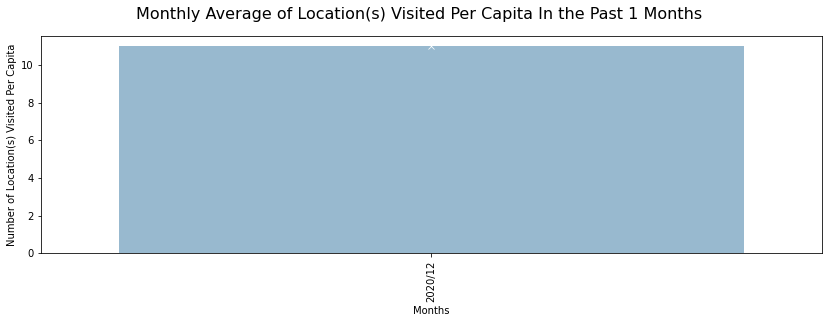

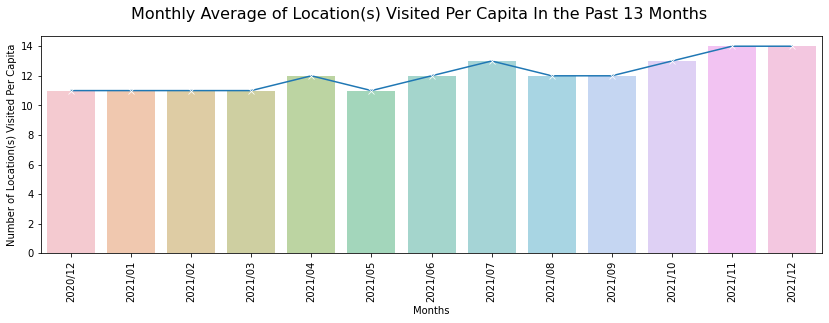

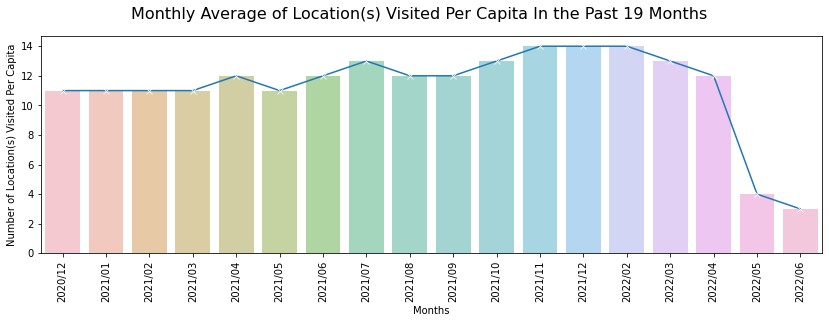

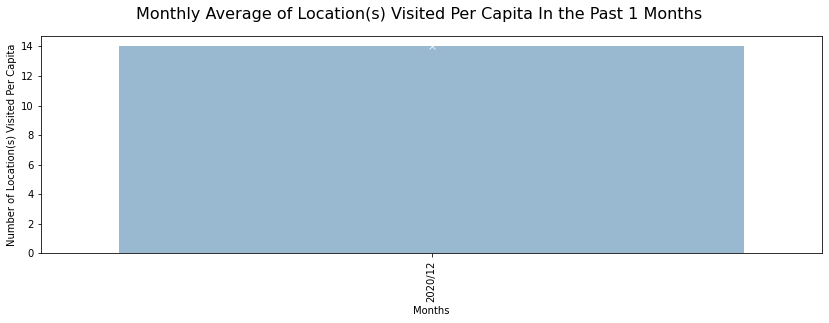

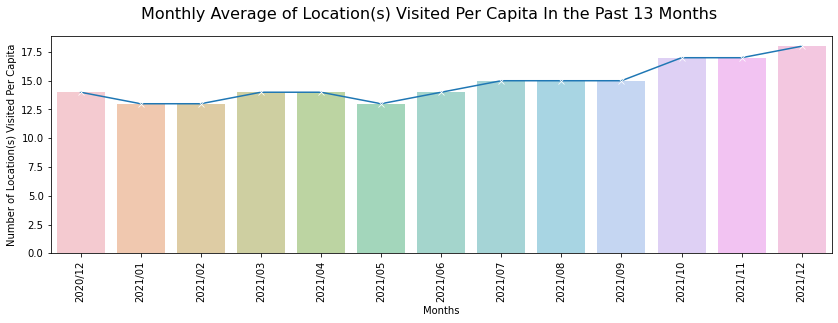

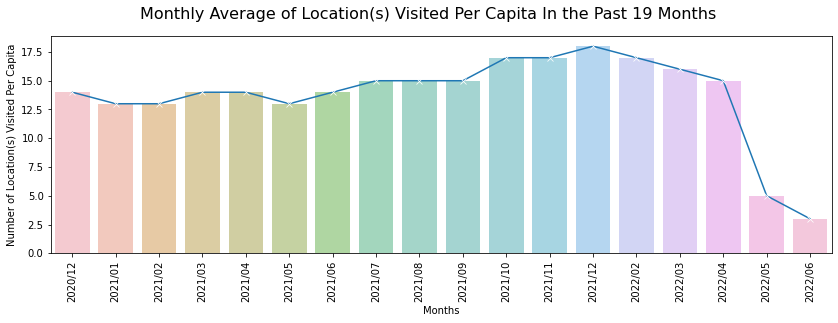

In [4]:
pt.get_mm_avg_visit_p_cap('national')
pt.get_mm_avg_visit_p_cap('state')

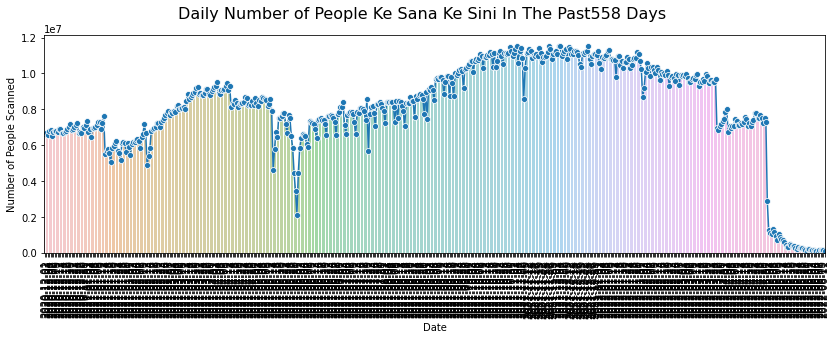

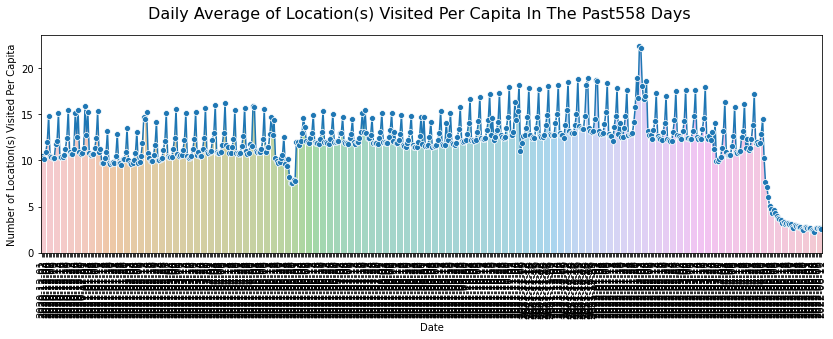

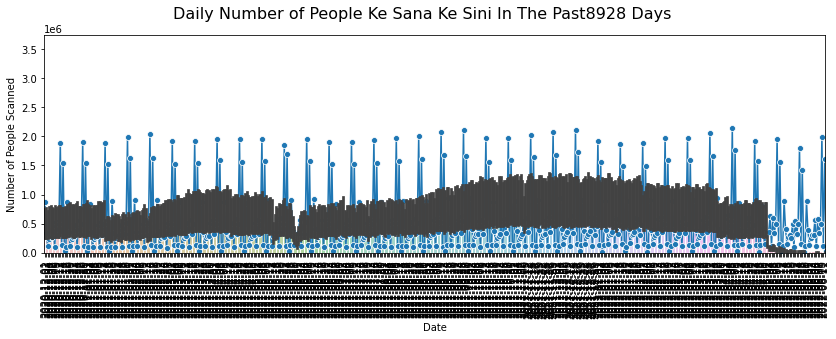

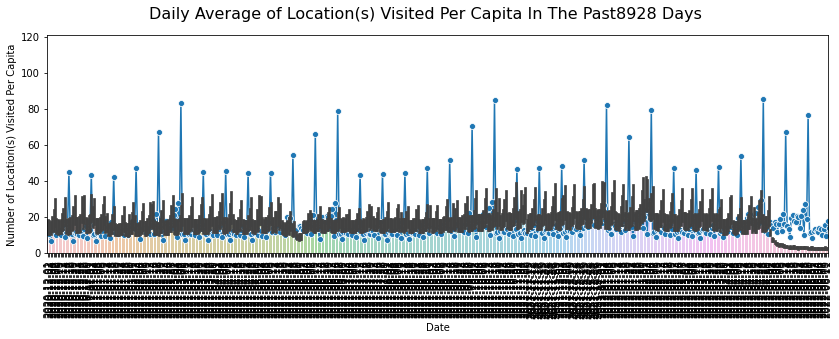

In [5]:
pt.get_dd_avg_visit_p_cap('national')
pt.get_dd_avg_visit_p_cap('state')